# Weeks 13-14

## Natural Language Processing
***

Read in some packages.

In [1]:
# Import pandas to read in data
import numpy as np
import pandas as pd

# Import models and evaluation functions
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn import cross_validation

# Import vectorizers to turn text into numeric
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Import plotting
import matplotlib.pylab as plt
%matplotlib inline

E:\java\anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Basic Feature Engineering
We have examined two ways of dealing with categorical (i.e. text based) data: binarizing/dummy variables and numerical scaling. 

See the following examples for implementation in sklearn to start:

In [2]:
data = pd.read_csv("data/categorical.csv")

In [3]:
data

,Minutes,Gender,Marital,Satisfaction,Churn
0,100,Male,Single,Low,0
1,220,Female,Married,Very Low,0
2,500,Female,Divorced,High,1
3,335,Male,Single,Neutral,0
4,450,Male,Married,Very High,1


### Binarizing
Get a list of features you want to binarize, go through each feature and create new features for each level.

In [4]:
features_to_binarize = ["Gender", "Marital"]

# Go through each feature
for feature in features_to_binarize:
    # Go through each level in this feature (except the last one!)
    for level in data[feature].unique()[0:-1]:
        # Create new feature for this level
        data[feature + "_" + level] = pd.Series(data[feature] == level, dtype=int)
    # Drop original feature
    data = data.drop([feature], 1)

In [5]:
data

,Minutes,Satisfaction,Churn,Gender_Male,Marital_Single,Marital_Married
0,100,Low,0,1,1,0
1,220,Very Low,0,0,0,1
2,500,High,1,0,0,0
3,335,Neutral,0,1,1,0
4,450,Very High,1,1,0,1


### Numeric scaling
We can also replace text levels with some numeric mapping we create

In [6]:
data['Satisfaction'] = data['Satisfaction'].replace(['Very Low', 'Low', 'Neutral', 'High', 'Very High'], 
                                                    [-2, -1, 0, 1, 2])

In [7]:
data

,Minutes,Satisfaction,Churn,Gender_Male,Marital_Single,Marital_Married
0,100,-1,0,1,1,0
1,220,-2,0,0,0,1
2,500,1,1,0,0,0
3,335,0,0,1,1,0
4,450,2,1,1,0,1


## Text classification
We are going to look at some Amazon reviews and classify them into positive or negative.

### Data
The file `data/books.csv` contains 2,000 Amazon book reviews. The data set contains two features: the first column (contained in quotes) is the review text. The second column is a binary label indicating if the review is positive or negative.

Let's take a quick look at the file.

In [8]:
!head -3 data/books.csv

'head' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


Let's read the data into a pandas data frame. You'll notice two new attributed in `pd.read_csv()` that we've never seen before. The first, `quotechar` is tell us what is being used to "encapsulate" the text fields. Since our review text is surrounding by double quotes, we let pandas know. We use a `\` since the quote is also used to surround the quote. This backslash is known as an escape character. We also let pandas now this.

In [9]:
data = pd.read_csv("data/books.csv", quotechar="\"", escapechar="\\")

In [10]:
data.head()

,review_text,positive
0,THis book was horrible. If it was possible to...,0
1,I like to use the Amazon reviews when purchasi...,0
2,THis book was horrible. If it was possible to...,0
3,"I'm not sure who's writing these reviews, but ...",0
4,I picked up the first book in this series (The...,0


### Text as a set of features
Going from text to numeric data is very easy. Let's take a look at how we can do this. We'll start by separating out our X and Y data.

In [11]:
X_text = data['review_text']
Y = data['positive']

In [12]:
# look at the first few lines of X_text
X_text.head()

0    THis book was horrible.  If it was possible to...
1    I like to use the Amazon reviews when purchasi...
2    THis book was horrible.  If it was possible to...
3    I'm not sure who's writing these reviews, but ...
4    I picked up the first book in this series (The...
Name: review_text, dtype: object

Do the same for Y

In [13]:
# your code here
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: positive, dtype: int64

Next, we will turn `X_text` into just `X` -- a numeric representation that we can use in our algorithms or for queries...

Text preprocessing, tokenizing and filtering of stopwords are all included in CountVectorizer, which builds a dictionary of features and transforms documents to feature vectors. 

The result of the following is a matrix with each row a file and each column a word. The matrix is sparse because most words only appear a few times. The values are 1 if a word appears in a document and 1 otherwise.

In [14]:
# Create a vectorizer that will track text as binary features
binary_vectorizer = CountVectorizer(binary=True)

# Let the vectorizer learn what tokens exist in the text data
binary_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = binary_vectorizer.transform(X_text)

In [15]:
# Dimensions of X:
X.shape


(2000, 22743)

There are 2000 documents (each row) and 22,743 words/tokens.

Can look at some of the words by querying the binary vectorizer:

In [16]:
# List of the 20 features (words) in column 10,000
features = binary_vectorizer.get_feature_names()
features[10000:10020]

['hygi',
 'hygience',
 'hygiene',
 'hyojin',
 'hype',
 'hyped',
 'hyper',
 'hyperbole',
 'hyperpat',
 'hyperpussiance',
 'hyperspace',
 'hypnosis',
 'hypnotic',
 'hypnotism',
 'hypnotizing',
 'hypocrisy',
 'hypocrite',
 'hypocritical',
 'hypocritically',
 'hypoglycemia']

Spend some time to look at the binary vectoriser.

Examine the structure of X. Look at some the rows and columns values.

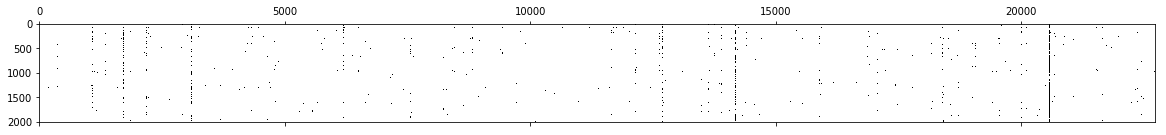

In [17]:
# see the density of 0s and 1s in X
import scipy.sparse as sps
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.spy(X.toarray())
plt.show()

Look at the sparse matrix above. Notice how some columns are quite dark (i.e. the words appear in almost every file). 

What are the 5 most common words?

In [18]:
# your code here
S = X.toarray().sum(axis=0)
sort = np.sort(S)
temp =sort[-6:-1]
words=[]
for i in range(len(features)):
    if S[i] in temp:
        words.append(features[i])
if len(words) >=5:
    words = words[0:5]
print(words)

['and', 'book', 'of', 'this', 'to']


Your answer here

Write a function that takes the sparse matrix X, and gets the feature list from the vectoriser, and a document index (1 - 2000) and returns a list of the words in the file that corresponds to the index (the list should be obtained from the sparse matrix / bag of words representation NOT from the original data file). 

In [19]:
# complete the function 
# returns vector of words / features
def getWords(bag_of_words, file_index_row, features_list):
    array = bag_of_words.toarray()
    row = array[file_index_row,:]
    result = []
    for r in range (len(row)):
        if(row[r]==1):
            result.append(features_list[r])
    return result

getWords(X, 1, features)


['about',
 'alert',
 'amazon',
 'and',
 'bashers',
 'book',
 'books',
 'by',
 'castigates',
 'dissenting',
 'distasteful',
 'disuades',
 'effect',
 'empathy',
 'especially',
 'example',
 'family',
 'for',
 'found',
 'from',
 'he',
 'higly',
 'his',
 'implausible',
 'indulgent',
 'it',
 'items',
 'like',
 'little',
 'me',
 'no',
 'of',
 'offer',
 'or',
 'panders',
 'people',
 'perceptions',
 'person',
 'play',
 'popularity',
 'portrayal',
 'purchasing',
 'questions',
 'rated',
 'reaches',
 'review',
 'reviews',
 'seems',
 'selection',
 'self',
 'seriously',
 'serving',
 'smug',
 'so',
 'that',
 'the',
 'therapist',
 'theshrink',
 'this',
 'throughout',
 'to',
 'tone',
 'use',
 'usually',
 'very',
 'was',
 'when',
 'which',
 'with',
 'work',
 'world',
 'written']

### Modeling
We have a 22743 features, let's use them in some different models.

In [20]:
# Create a model
logistic_regression = LogisticRegression()

# Use this model and our data to get 5-fold cross validation accuracy
acc = cross_validation.cross_val_score(logistic_regression, X, Y, scoring="accuracy", cv=5)

# Print out the average accuracy rounded to three decimal points
print ("Mean accuracy of our classifier is " + str(round(np.mean(acc), 3)) )

Mean accuracy of our classifier is 0.768


In [21]:
new_review = """"
really bad book!
"""

# your code here ...
words = new_review.split(' ')
matrix = []
for r in range(len(features)):
    if features[r] not in words:
        matrix.append(0)
    else:
        matrix.append(1)
logistic = logistic_regression.fit(X.toarray(),Y)

predict = logistic_regression.predict([matrix])
if(predict!=0):
    print("Positive review")
else:
    print("Negative review")


Negative review


In [22]:
#Use the above classifier to classify a new example (new review below):

Let's try using full counts instead of a binary representation (i.e. each time a word appears use the raw count value). 

In [23]:
# Create a vectorizer that will track text as binary features
count_vectorizer = CountVectorizer()

# Let the vectorizer learn what tokens exist in the text data
count_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = count_vectorizer.transform(X_text)

# Create a model
logistic_regression = LogisticRegression()

# Use this model and our data to get 5-fold cross validation accuracy
acc = cross_validation.cross_val_score(logistic_regression, X, Y, scoring="accuracy", cv=5)

# Print out the average AUC rounded to three decimal points
print( "Accuracy for our classifier is " + str(round(np.mean(acc), 3)) )

Accuracy for our classifier is 0.786


Now try using TF-IDF:

In [24]:
# Create a vectorizer that will track text as binary features
tfidf_vectorizer = TfidfVectorizer()

# Let the vectorizer learn what tokens exist in the text data
tfidf_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = tfidf_vectorizer.transform(X_text)

# Create a model
logistic_regression = LogisticRegression()

# Use this model and our data to get 5-fold cross validation AUCs
acc = cross_validation.cross_val_score(logistic_regression, X, Y, scoring="accuracy", cv=5)

# Print out the average AUC rounded to three decimal points
print( "Accuracy for our classifier is " + str(round(np.mean(acc), 3)) )

Accuracy for our classifier is 0.784


Use the tfidf classifier to classify some online book reviews from here: https://www.amazon.com/

Hint: You can copy and paste a review from the online site into a multiline string literal with 3 quotes: 
```
"""
copied and pasted
multiline
string...
"""
```

In [25]:
# your code here
words = new_review.split(' ')
matrix = []
for r in range(len(features)):
    if features[r] not in words:
        matrix.append(0)
    else:
        matrix.append(1)
logistic = logistic_regression.fit(X.toarray(),Y)

predict = logistic_regression.predict([matrix])
if(predict!=0):
    print("positive review")
else:
    print("negative review")

negative review


### Extending the implementation
#### Features
Tfidf is looking pretty good! How about adding n-grams? Stop words? Lowercase transforming?

We saw that the most common words include "the" and others above - start by making these stop words.

N-grams are conjunctions of words (e.g. a 2-gram adds all sequences of 2 words)


Look at the docs: `CountVectorizer()` and `TfidfVectorizer()` can be modified to handle all of these things. Work in groups and try a few different combinations of these settings for anything you want: binary counts, numeric counts, tf-idf counts. Here is how you would use these settings:

- "`ngram_range=(1,2)`": would include unigrams and bigrams (ie including combinations of words in sequence)
- "`stop_words="english"`": would use a standard set of English stop words
- "`lowercase=False`": would turn off lowercase transformation (it is actually on by default)!

You can use some of these like this:

`tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), lowercase=False)`

#### Models
Next swap out the line creating a logistic regression with one making a naive Bayes or support vector machines (SVM). SVM have been shown to be very effective in text classification. Naive Bayes has been used a lot also.

For example see: http://www.cs.cornell.edu/home/llee/papers/sentiment.pdf


In [26]:
# Try different features, models, or both!
# What is the highest accuracy you can get?

In [27]:
result = []
names = []

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), lowercase=False)
tfidf_vectorizer.fit(X_text)
numeric_X = tfidf_vectorizer.transform(X_text)

LinearSVC  = LinearSVC()
MultinomialNB = MultinomialNB()
acc_SVC = cross_validation.cross_val_score(LinearSVC, numeric_X, Y, scoring="accuracy", cv=5)
acc_NB = cross_validation.cross_val_score(MultinomialNB, numeric_X, Y, scoring="accuracy", cv=5)
names.append("combine-svm")
names.append("combine-NB")
result.append(round(np.mean(acc_SVC), 3))
result.append(round(np.mean(acc_NB), 3))
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
tfidf_vectorizer = TfidfVectorizer()

tfidf_vectorizer.fit(X_text)
numeric_X = tfidf_vectorizer.transform(X_text)

LinearSVC  = LinearSVC()
MultinomialNB = MultinomialNB()
acc_SVC = cross_validation.cross_val_score(LinearSVC, numeric_X, Y, scoring="accuracy", cv=5)
acc_NB = cross_validation.cross_val_score(MultinomialNB, numeric_X, Y, scoring="accuracy", cv=5)
names.append("default-svm")
names.append("default-NB")
result.append(round(np.mean(acc_SVC), 3))
result.append(round(np.mean(acc_NB), 3))

[0.81, 0.789, 0.788, 0.766]


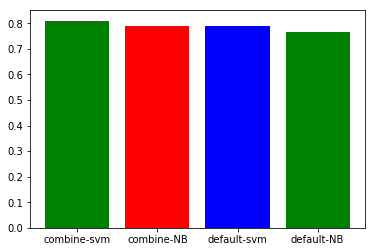

In [29]:
print(result)
plt.bar(range(len(result)), result,color='grb',tick_label=names)
plt.show()

[0.81, 0.789, 0.788, 0.766, 0.777, 0.798, 0.767, 0.765, 0.777, 0.798, 0.767, 0.765]
['combine-svm', 'combine-NB', 'default-svm', 'default-NB', 'counter combine-svm', 'counter combine-NB', 'counter default-svm', 'counter default-NB', 'counter combine-svm', 'counter combine-NB', 'counter default-svm', 'counter default-NB']


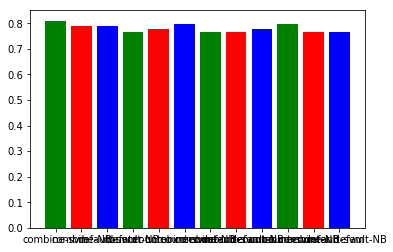

In [34]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

count_vectorizer = CountVectorizer(ngram_range=(1,2), lowercase=False)
count_vectorizer.fit(X_text)
numeric_X = count_vectorizer.transform(X_text)

LinearSVC  = LinearSVC()
MultinomialNB = MultinomialNB()
acc_SVC = cross_validation.cross_val_score(LinearSVC, numeric_X, Y, scoring="accuracy", cv=5)
acc_NB = cross_validation.cross_val_score(MultinomialNB, numeric_X, Y, scoring="accuracy", cv=5)

names.append("counter combine-svm")
names.append("counter combine-NB")
result.append(round(np.mean(acc_SVC), 3))
result.append(round(np.mean(acc_NB), 3))

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

count_vectorizer = CountVectorizer()
count_vectorizer.fit(X_text)
numeric_X = count_vectorizer.transform(X_text)

LinearSVC  = LinearSVC()
MultinomialNB = MultinomialNB()
acc_SVC = cross_validation.cross_val_score(LinearSVC, numeric_X, Y, scoring="accuracy", cv=5)
acc_NB = cross_validation.cross_val_score(MultinomialNB, numeric_X, Y, scoring="accuracy", cv=5)

names.append("counter default-svm")
names.append("counter default-NB")
result.append(round(np.mean(acc_SVC), 3))
result.append(round(np.mean(acc_NB), 3))
print(result)
print(names)
plt.bar(range(len(result)), result,color='grb',tick_label=names)
plt.show()

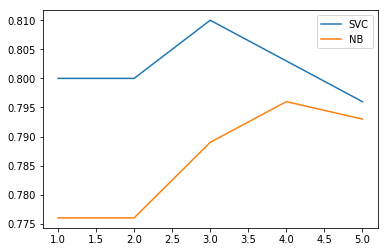

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pylab as plt
%matplotlib inline

accs_SVC = []
accs_NB = []
for i in range(5):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,i), lowercase=False)

    tfidf_vectorizer.fit(X_text)
    numeric_X = tfidf_vectorizer.transform(X_text)

    Linear  = LinearSVC()
    Multi = MultinomialNB()

    acc_SVC = cross_validation.cross_val_score(Linear, numeric_X, Y, scoring="accuracy", cv=5)
    acc_NB = cross_validation.cross_val_score(Multi, numeric_X, Y, scoring="accuracy", cv=5)

    accs_SVC.append(round(np.mean(acc_SVC), 3))
    accs_NB.append(round(np.mean(acc_NB), 3))

i=[1,2,3,4,5]
plt.plot(i, accs_SVC, label="SVC")
plt.plot(i, accs_NB, label="NB")
plt.legend()

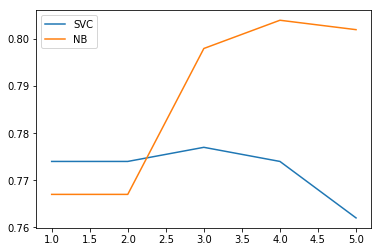

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pylab as plt
%matplotlib inline

accs_SVC = []
accs_NB = []
for i in range(5):
    count_vectorizer = CountVectorizer(ngram_range=(1,i), lowercase=False)
    count_vectorizer.fit(X_text)
    numeric_X = count_vectorizer.transform(X_text)

    Linear  = LinearSVC()
    Multi = MultinomialNB()

    acc_SVC = cross_validation.cross_val_score(Linear, numeric_X, Y, scoring="accuracy", cv=5)
    acc_NB = cross_validation.cross_val_score(Multi, numeric_X, Y, scoring="accuracy", cv=5)

    accs_SVC.append(round(np.mean(acc_SVC), 3))
    accs_NB.append(round(np.mean(acc_NB), 3))

i=[1,2,3,4,5]
plt.plot(i, accs_SVC, label="SVC")
plt.plot(i, accs_NB, label="NB")
plt.legend()